# 累積カーブをダミーで生成してシグモイド関数でfittingする

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmdstanpy

# dummy dataを生成する

## シグモイド

In [2]:
import numpy as np
import pandas as pd

def _build_irregular_anchors(x_min, x_max, mean_step, step_std, min_step, max_step, rng):
    xs = [x_min]
    while xs[-1] < x_max:
        step = int(np.round(rng.normal(mean_step, step_std)))
        step = int(np.clip(step, min_step, max_step))
        nxt = xs[-1] + step
        if nxt >= x_max:
            xs.append(x_max)
            break
        xs.append(nxt)
    return np.array(xs, dtype=int)

def _sigmoid_params_from_psat(x0, p_sat, eps):
    """
    y = 10 / (1 + exp(-k*(x - x0))) として、
    x = p_sat で y = 10*(1 - eps) になるように k を決める。
    """
    # Δ = p_sat - x0 (>0を想定)
    delta = float(p_sat - x0)
    if delta <= 0:
        delta = 1.0  # 念のためのガード
    k = (1.0 / delta) * np.log((1.0 - eps) / eps)
    return k

def _sigmoid_scaled(x, x0, k):
    s = 1.0 / (1.0 + np.exp(-k * (x - x0)))
    return 10.0 * s  # [0,10] にスケール

def hour_to_psat(
    hour: int,
    low: int = 1500,
    high: int = 2000,
    phase_shift_hours: float = 6.0,
) -> float:
    """
    時刻(hour)→ p_sat（yが10にほぼ達する価格）を周期(24h)で決める。
    sin波で [low, high] に写像。phase_shift_hours で位相を調整。
    """
    mid = 0.5 * (low + high)
    amp = 0.5 * (high - low)
    # 0..23 を 0..2π に変換し位相をずらす（朝方高くしたい等の調整に）
    theta = 2.0 * np.pi * ((hour - phase_shift_hours) % 24) / 24.0
    return mid + amp * np.sin(theta)

def make_sigmoid_like_dataset_for_hour(
    hour: int,
    x_min: int = 0,
    x_max: int = 2000,
    mean_step: int = 20,
    step_std: int = 7,
    min_step: int = 5,
    max_step: int = 35,
    x0: float = 1000.0,      # シグモイド中心（固定）
    eps: float = 1e-3,       # p_satで"ほぼ"10(=10*(1-eps))に到達
    noise_sd_low: float = 0.02,
    noise_sd_mid: float = 0.08,
    phase_shift_hours: float = 6.0,  # 周期の山/谷の時刻調整
    p_sat_low: int = 1500,
    p_sat_high: int = 2000,
    seed: int = None,
    save_csv_path: str | None = None,
) -> pd.DataFrame:
    """
    指定時刻(hour)の累積入札量ダミーデータを作成。
    - yは[0,10]にクリップ、単調増加（非減少）を保証
    - アンカー間はギャップごとに ffill/bfill をランダム適用
    返り値: DataFrame[x, y, is_anchor, fill_method, hour, p_sat]
    """
    rng = np.random.default_rng(seed)

    # --- 時刻に応じた p_sat を決定（1500〜2000） ---
    p_sat = hour_to_psat(hour, low=p_sat_low, high=p_sat_high, phase_shift_hours=phase_shift_hours)

    # --- その p_sat で 10*(1-eps) に達するように傾き k を決める ---
    k = _sigmoid_params_from_psat(x0=x0, p_sat=p_sat, eps=eps)

    # --- 不均一アンカー x ---
    anchors_x = _build_irregular_anchors(x_min, x_max, mean_step, step_std, min_step, max_step, rng)

    # --- アンカー y（軽いノイズ; 中央でやや大きく） ---
    base_y = _sigmoid_scaled(anchors_x, x0=x0, k=k)
    mid_weight = 1.0 - np.abs((anchors_x - x0) / (x0 - x_min))  # 端0, 中央1（x_min<x0想定）
    noise_sd = noise_sd_low + (noise_sd_mid - noise_sd_low) * np.clip(mid_weight, 0, 1)
    noisy = base_y + rng.normal(0.0, noise_sd)
    noisy = np.clip(noisy, 0.0, 10.0)

    # --- 単調増加（非減少）保証：累積最大 ---
    anchors_y = np.maximum.accumulate(noisy)
    anchors_y = np.clip(anchors_y, 0.0, 10.0)

    # --- 全xに拡張し、各ギャップで ffill/bfill をランダム適用 ---
    full_x = np.arange(x_min, x_max + 1, dtype=int)
    y = np.full(full_x.shape, np.nan, dtype=float)

    anchor_mask = np.zeros_like(full_x, dtype=bool)
    anchor_idx = np.searchsorted(full_x, anchors_x)
    anchor_mask[anchor_idx] = True
    y[anchor_idx] = anchors_y

    fill_method = np.full(full_x.shape, "", dtype=object)
    for i in range(len(anchor_idx) - 1):
        s, e = anchor_idx[i], anchor_idx[i + 1]
        method = rng.choice(["ffill", "bfill"])
        if method == "ffill":
            y[s + 1 : e] = y[s]
            fill_method[s + 1 : e] = "ffill"
        else:
            y[s + 1 : e] = y[e]
            fill_method[s + 1 : e] = "bfill"

    # クリップ＆最終単調性担保
    y = np.clip(y, 0.0, 10.0)
    if not np.all(np.diff(y) >= -1e-12):
        y = np.maximum.accumulate(y)

    df = pd.DataFrame(
        {
            "x": full_x,
            "y": y,
            "is_anchor": anchor_mask,
            "fill_method": fill_method,
            "hour": hour,
            "p_sat": p_sat,  # その時刻で 10 にほぼ到達する価格
        }
    )

    if save_csv_path:
        df.to_csv(save_csv_path, index=False)

    return df

def make_all_hours_dataset(
    **kwargs
) -> pd.DataFrame:
    """
    0〜23時すべてのデータを縦結合して返す。
    kwargs は make_sigmoid_like_dataset_for_hour にそのまま渡される。
    """
    frames = [make_sigmoid_like_dataset_for_hour(hour=h, **kwargs) for h in range(24)]
    return pd.concat(frames, ignore_index=True)

# # --- 使い方例 ---
# if __name__ == "__main__":
#     # 例: 7時のシリーズを作成して保存
#     df7 = make_sigmoid_like_dataset_for_hour(
#         hour=7,
#         save_csv_path="bids_hour07.csv",
#         seed=123
#     )
#     print(df7.head(), df7.tail())

#     # 例: 24時間ぶんを作って確認
#     df_all = make_all_hours_dataset(seed=123)
#     print(df_all.groupby("hour")["p_sat"].agg(["min","max","mean"]))

In [5]:
dflist = []
for date in pd.date_range("2022-01-01", "2022-01-30", freq="D"):
    df_all = make_all_hours_dataset()
    df_all["date"] = date
    dflist.append(df_all)
dfout = pd.concat(dflist)

In [6]:
dfout[["date","x","y","hour",]].to_parquet("../customdataset/accum_curve_dataset.parquet",compression="lz4")

In [4]:
dfout = df_all.pivot_table(index="x", columns="hour", values="y")

In [99]:
df_all

,x,y,is_anchor,fill_method,hour,p_sat
0,0,0.0,True,,0,1500.000000
1,1,0.0,False,ffill,0,1500.000000
2,2,0.0,False,ffill,0,1500.000000
3,3,0.0,False,ffill,0,1500.000000
4,4,0.0,False,ffill,0,1500.000000
...,...,...,...,...,...,...
48019,1996,10.0,False,ffill,23,1508.518543
48020,1997,10.0,False,ffill,23,1508.518543
48021,1998,10.0,False,ffill,23,1508.518543
48022,1999,10.0,True,,23,1508.518543


In [108]:
dfout[["date","x","y","hour",]].to_csv("../customdataset/accum_curve_dataset.csv.gz",compression="gzip")

## シグモイド＋1次関数

In [13]:
import numpy as np
import pandas as pd

# --------- 共通ユーティリティ ---------

def _build_irregular_anchors(x_min, x_max, mean_step, step_std, min_step, max_step, rng):
    xs = [x_min]
    while xs[-1] < x_max:
        step = int(np.round(rng.normal(mean_step, step_std)))
        step = int(np.clip(step, min_step, max_step))
        nxt = xs[-1] + step
        if nxt >= x_max:
            xs.append(x_max)
            break
        xs.append(nxt)
    return np.array(xs, dtype=int)

def _sigmoid_params_from_psat(x0, p_sat, eps):
    """
    y = 10 / (1 + exp(-k*(x - x0))) として、
    x = p_sat で y = 10*(1 - eps) になるように k を決める。
    """
    delta = float(p_sat - x0)
    if delta <= 0:
        delta = 1.0  # ガード
    return (1.0 / delta) * np.log((1.0 - eps) / eps)

def _sigmoid_scaled(x, x0, k):
    s = 1.0 / (1.0 + np.exp(-k * (x - x0)))
    return 10.0 * s  # 上限10のシグモイド

# --------- 線形“段差”区間 ---------

def _build_linear_stepwise_series(
    x_start: int,
    x_end: int,
    y_start: float,
    rng: np.random.Generator,
    mean_step: int = 3,
    step_std: int = 1,
    min_step: int = 1,
    max_step: int = 6,
    base_jump: float = 0.06,        # 段差の平均“高さ”（yは0..10想定）
    jump_jitter_sd: float = 0.025,  # 段差高さノイズ（非負化）
):
    """
    x_start..x_end を完全な段差（フラット→ジャンプ）で単調増加させる。
    各ステップ幅に乱れ、ジャンプ量にノイズ。区間内の傾きは常に0。
    返り値は (x, y) の ndarray（x_start を含む）。
    """
    xs = [x_start]
    ys = [float(y_start)]
    x_cur = int(x_start)
    y_cur = float(y_start)

    while x_cur < x_end:
        # ステップ幅（フラット区間）
        width = int(np.clip(np.round(rng.normal(mean_step, step_std)), min_step, max_step))
        x_next = min(x_cur + width, x_end)

        # このフラット区間は y_cur のまま
        for x in range(x_cur + 1, x_next + 1):
            xs.append(x)
            ys.append(y_cur)

        # 境界でジャンプ（最後はジャンプせず終了）
        if x_next < x_end:
            jump = max(0.0, rng.normal(base_jump, jump_jitter_sd))
            y_cur = y_cur + jump
        x_cur = x_next

    return np.asarray(xs, dtype=int), np.asarray(ys, dtype=float)

# --------- メイン：縮小レンジ版（シグモイド + 段差線形） ---------

def make_smallrange_sigmoid_plus_linear_steps_for_hour(
    hour: int,
    # --- シグモイド部 ---
    x_min: int = 0,
    x_sig_end: int = 200,           # ← 縮小レンジ：シグモイドはここまで
    x0: float = 100.0,              # 縮小レンジに合わせて中心も縮める（例）
    eps: float = 1e-3,
    mean_step_sig: int = 3,         # 刻みの平均 ~3（以前の1/10スケール感）
    step_std_sig: int = 1,
    min_step_sig: int = 1,
    max_step_sig: int = 6,
    noise_sd_low: float = 0.02,
    noise_sd_mid: float = 0.08,
    p_sat_low: int = 150,           # ← ほぼ上限到達 x を 150〜200 に
    p_sat_high: int = 200,
    # --- 段差線形部 ---
    x_linear_end: int = 500,        # ← 線形区間の終端
    mean_step_lin: int = 3,
    step_std_lin: int = 1,
    min_step_lin: int = 1,
    max_step_lin: int = 6,
    base_jump: float = 0.06,
    jump_jitter_sd: float = 0.025,
    connect_margin: int = 8,        # ← p_sat より手前から接続（縮小レンジ向け）
    # --- その他 ---
    seed: int = 42,
    save_csv_path: str | None = None,
) -> pd.DataFrame:
    """
    指定時刻(hour)について：
      * x∈[0, ~150-200] は“階段状シグモイド”（上限≈10）
      * x∈[~150-200, 500] は“完全な段差の線形成長”
        - 線形開始 x_lin_start = round(p_sat - connect_margin)
        - 段差の幅・高さにノイズ
      * x= x_lin_start の y はシグモイド値に合わせ、連続に接続
    返り値: DataFrame[x, y, phase, hour, p_sat]
            phase: 'sigmoid' or 'linear'
    """
    rng = np.random.default_rng(seed)

    # p_sat を（ここでは時間に依存させず）一様に選ぶ例
    p_sat = rng.integers(p_sat_low, p_sat_high + 1)

    # その p_sat で 10*(1-eps) になる傾き k を算出
    k = _sigmoid_params_from_psat(x0=x0, p_sat=p_sat, eps=eps)

    # --- シグモイド部の不均一アンカー ---
    anchors_x = _build_irregular_anchors(x_min, x_sig_end, mean_step_sig, step_std_sig, min_step_sig, max_step_sig, rng)
    base_y = _sigmoid_scaled(anchors_x, x0=x0, k=k)

    # 中央でややノイズを大きく
    mid_weight = 1.0 - np.abs((anchors_x - x0) / max(1e-9, (x0 - x_min)))
    noise_sd = noise_sd_low + (noise_sd_mid - noise_sd_low) * np.clip(mid_weight, 0, 1)
    noisy = base_y + rng.normal(0.0, noise_sd)
    anchors_y = np.maximum.accumulate(np.clip(noisy, 0.0, 10.0))

    # --- 1刻みへ展開（ffill/bfill ランダム）---
    full_x_sig = np.arange(x_min, x_sig_end + 1, dtype=int)
    y_sig = np.full_like(full_x_sig, np.nan, dtype=float)
    anchor_idx = np.searchsorted(full_x_sig, anchors_x)
    y_sig[anchor_idx] = anchors_y

    for i in range(len(anchor_idx) - 1):
        s, e = anchor_idx[i], anchor_idx[i + 1]
        if rng.random() < 0.5:
            y_sig[s + 1:e] = y_sig[s]   # ffill
        else:
            y_sig[s + 1:e] = y_sig[e]   # bfill
    y_sig = np.maximum.accumulate(y_sig)

    # --- 線形段差の開始点を p_sat より手前に ---
    x_lin_start = int(np.clip(int(np.round(p_sat - connect_margin)), x_min, x_sig_end))
    y_start = y_sig[x_lin_start - x_min]

    # --- 段差線形区間 ---
    xs_lin, ys_lin = _build_linear_stepwise_series(
        x_start=x_lin_start,
        x_end=x_linear_end,
        y_start=y_start,
        rng=rng,
        mean_step=mean_step_lin,
        step_std=step_std_lin,
        min_step=min_step_lin,
        max_step=max_step_lin,
        base_jump=base_jump,
        jump_jitter_sd=jump_jitter_sd,
    )

    # --- 連結（x_lin_start 以降は段差線形を優先）---
    mask_sig = (full_x_sig < x_lin_start)
    x_out = np.concatenate([full_x_sig[mask_sig], xs_lin])
    y_out = np.concatenate([y_sig[mask_sig], ys_lin])
    phase = np.array(["sigmoid"] * mask_sig.sum() + ["linear"] * len(xs_lin))

    df = pd.DataFrame(
        {"x": x_out.astype(int),
         "y": y_out.astype(float),
         "phase": phase,
         "hour": hour,
         "p_sat": float(p_sat)}
    )

    if save_csv_path:
        df.to_csv(save_csv_path, index=False)

    return df

# --- 例 ---
if __name__ == "__main__":
    dflist = []
    for hour in range(0,24):
        df = make_smallrange_sigmoid_plus_linear_steps_for_hour(
            hour=hour,
            x_sig_end=200,
            p_sat_low=150, p_sat_high=200,
            x0=100.0,                 # 縮小レンジの中心
            connect_margin=10,        # p_sat の10手前から段差開始
            mean_step_sig=3, step_std_sig=1,
            mean_step_lin=3, step_std_lin=1,
            base_jump=0.06, jump_jitter_sd=0.025,
            x_linear_end=500,
            seed=hour+123,
        )
        dflist.append(df)
    dfout = pd.concat(dflist)


In [19]:
dfout.to_parquet("../../customdataset/accum_curve_linear_dataset.parquet", compression="lz4")

In [16]:
dfpv = dfout.pivot_table(index="x", columns="hour", values="y")

<Axes: xlabel='x'>

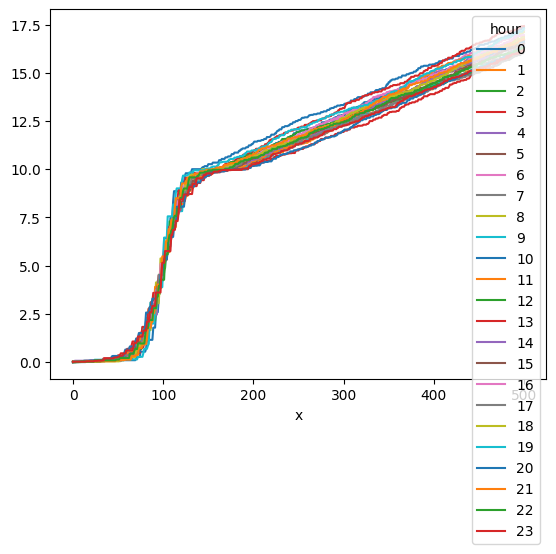

In [18]:
dfpv.plot()
